In [2]:

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# enable inline plotting for notebooks
get_ipython().run_line_magic('matplotlib', 'inline')

COLOR_MAP = {"G1":"#F1C40F","G2":"#3498DB","G3":"#2ECC71","G4":"#E91E63"}
GROUPS = ["G1","G2","G3","G4"]
SESSION_ORDER_PREF = ["T0","P1","T1","P2","T2","P3","T3","P4","T4","P5","T5"]


In [3]:

def _coerce_perf_wide_to_tidy(df):
    # Convert wide 'Metrics' format to tidy.
    cols_lower = [c.lower() for c in df.columns]
    lo = {c.lower(): c for c in df.columns}  # lower->original
    colset = set(cols_lower)
    if {"metrics","participant_id","group_id"}.issubset(colset):
        long = df.melt(
            id_vars=[lo["metrics"],lo["participant_id"],lo["group_id"]],
            var_name="session", value_name="value"
        )
        long.columns = [c.lower() for c in long.columns]
        piv = long.pivot_table(
            index=["participant_id","group_id","session"],
            columns="metrics", values="value"
        ).reset_index()
        piv.columns = [c.lower() for c in piv.columns]
        piv["group"] = piv["group_id"].map({1:"G1",2:"G2",3:"G3",4:"G4"})
        if "correctness" in piv.columns:
            piv["correctness"] = pd.to_numeric(piv["correctness"], errors="coerce")
        if "time" in piv.columns:
            piv["time_min"] = pd.to_numeric(piv["time"], errors="coerce")
        piv["session"] = piv["session"].astype(str)
        keep = ["participant_id","group","session"]
        if "correctness" in piv.columns: keep.append("correctness")
        if "time_min" in piv.columns: keep.append("time_min")
        return piv[keep]
    return df

def order_sessions(session_values):
    seen = set()
    ordered = [s for s in SESSION_ORDER_PREF if s in session_values and not (s in seen or seen.add(s))]
    rest = [s for s in session_values if s not in set(ordered)]
    def natkey(s):
        prefix = ''.join([ch for ch in s if ch.isalpha()]) or ""
        digits = ''.join([ch for ch in s if ch.isdigit()]) or "0"
        return (prefix, int(digits))
    ordered += sorted(rest, key=natkey)
    return ordered

def bootstrap_ci(data, stat_func=np.median, B=2000, alpha=0.05):
    arr = np.array(data, dtype=float)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return np.nan, np.nan, np.nan
    stat = stat_func(arr)
    boots = np.array([stat_func(np.random.choice(arr, size=len(arr), replace=True)) for _ in range(B)])
    lo = np.percentile(boots, 100*alpha/2)
    hi = np.percentile(boots, 100*(1-alpha/2))
    return stat, lo, hi

def ci_prop(mean, n, alpha=0.05):
    if n == 0 or np.isnan(mean):
        return np.nan, np.nan, np.nan
    lo, hi = stats.binom.interval(1-alpha, n, mean, loc=0)
    return mean, lo/n, hi/n


## Load your CSV

In [4]:
CSV_PATH = "Performance - correctness_time.csv"

raw = pd.read_csv(CSV_PATH)

print("Shape:", raw.shape)
print("Columns:", list(raw.columns))
display(raw.head())


Shape: (86, 14)
Columns: ['Metrics', 'Participant_ID', 'Group_ID', 'T0', 'P1', 'T1', 'P2', 'T2', 'P3', 'T3', 'P4', 'T4', 'P5', 'T5']


,Metrics,Participant_ID,Group_ID,T0,P1,T1,P2,T2,P3,T3,P4,T4,P5,T5
0,Correctness,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Correctness,2,2,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
2,Correctness,3,3,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,Correctness,4,4,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
4,Correctness,5,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0


## Coerce to tidy format and preview

In [5]:

df = _coerce_perf_wide_to_tidy(raw.copy())

# Normalize column names if already tidy
lower_map = {c.lower(): c for c in df.columns}
if "group" in lower_map and lower_map["group"] != "group":
    df = df.rename(columns={lower_map["group"]:"group"})
if "session" in lower_map and lower_map["session"] != "session":
    df = df.rename(columns={lower_map["session"]:"session"})

# If numeric group, map to labels
if "group" in df.columns and pd.api.types.is_numeric_dtype(df["group"]):
    df["group"] = df["group"].map({1:"G1",2:"G2",3:"G3",4:"G4"})

df.head(10)


,participant_id,group,session,correctness,time_min
0,1,G1,P1,0.0,30.42
1,1,G1,P2,0.0,53.23
2,1,G1,P3,0.0,30.89
3,1,G1,P4,0.0,20.31
4,1,G1,P5,0.0,43.38
5,1,G1,T0,0.0,44.42
6,1,G1,T1,0.0,36.58
7,1,G1,T2,1.0,24.25
8,1,G1,T3,0.0,25.03
9,1,G1,T4,0.0,34.46


## Sanity checks

In [6]:

print("Rows:", len(df))
print("Columns:", list(df.columns))
print("Sessions:", sorted(df["session"].unique().tolist()))
print("Groups:", sorted(df["group"].unique().tolist()))
if "correctness" in df.columns:
    print("\nCorrectness summary by session/group:")
    display(df.groupby(["session","group"])["correctness"].agg(["count","mean"]).round(3))
if "time_min" in df.columns:
    print("\nTime summary by session/group (median):")
    display(df.groupby(["session","group"])["time_min"].median().round(2))


Rows: 465
Columns: ['participant_id', 'group', 'session', 'correctness', 'time_min']
Sessions: ['P1', 'P2', 'P3', 'P4', 'P5', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5']
Groups: ['G1', 'G2', 'G3', 'G4']

Correctness summary by session/group:


count   mean
session group              
P1      G1        11  0.545
        G2        11  0.455
        G3        11  0.545
        G4        10  0.700
P2      G1        11  0.364
        G2        11  0.636
        G3        11  0.455
        G4        10  0.700
P3      G1        11  0.364
        G2        10  0.500
        G3        11  0.455
        G4        10  0.900
P4      G1        11  0.636
        G2        10  0.500
        G3        11  0.455
        G4        10  0.500
P5      G1        10  0.400
        G2        10  0.500
        G3        11  0.455
        G4        10  0.800
T0      G1        11  0.364
        G2        11  0.364
        G3        11  0.273
        G4        10  0.300
T1      G1        11  0.182
        G2        11  0.182
        G3        11  0.545
        G4        10  0.800
T2      G1        11  0.455
        G2        11  0.545
        G3        11  0.545
        G4        10  0.900
T3      G1        11  0.545
        G2        10  0.500
        G3        11  0.636
        G4        10  0.800
T4      G1        11  0.455
        G2        10  0.500
        G3        11  0.455
        G4        10  0.900
T5      G1        10  0.500
        G2        10  0.400
        G3        11  0.364
        G4        10  0.800


Time summary by session/group (median):


session  group
P1       G1       23.43
         G2       25.25
         G3       30.42
         G4       25.84
P2       G1       17.85
         G2       17.85
         G3       28.20
         G4       20.66
P3       G1       25.23
         G2       22.18
         G3       36.08
         G4       18.43
P4       G1       20.31
         G2       15.66
         G3       26.16
         G4       27.23
P5       G1       24.70
         G2       19.87
         G3       19.15
         G4       14.51
T0       G1       44.42
         G2       34.40
         G3       37.46
         G4       37.80
T1       G1       30.34
         G2       30.76
         G3       23.68
         G4        7.81
T2       G1       20.48
         G2       19.96
         G3       19.18
         G4       12.76
T3       G1       23.38
         G2       25.92
         G3       23.57
         G4       12.14
T4       G1       21.05
         G2       28.64
         G3       25.98
         G4       12.67
T5       G1       24.58
 

## Plot: Correctness by Group × Session (points + mean 95% CI)

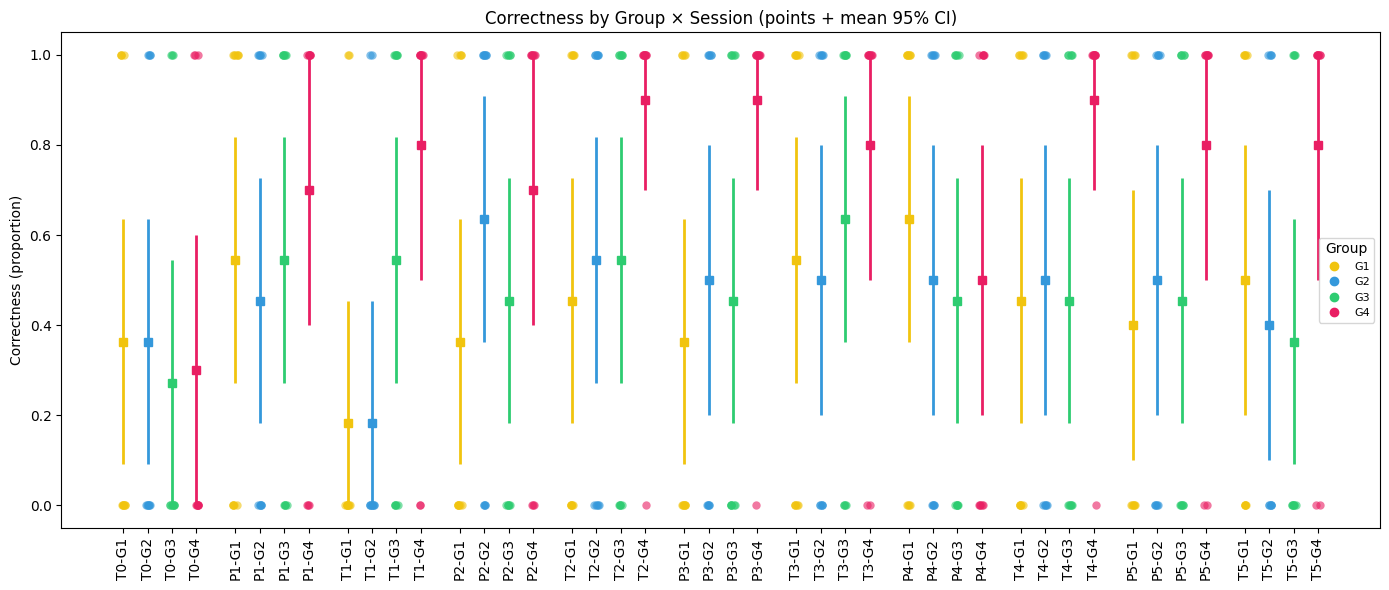

In [7]:

if "correctness" not in df.columns:
    print("No 'correctness' column found; skipping this plot.")
else:
    sessions = order_sessions(sorted(df["session"].unique()))
    fig, ax = plt.subplots(figsize=(14,6))
    xpos, labels, x = [], [], 0
    for s in sessions:
        sub = df[df["session"]==s]
        for g in GROUPS:
            gsub = sub[sub["group"]==g]
            y = gsub["correctness"].to_numpy(dtype=float)
            c = COLOR_MAP[g]
            xx = np.full_like(y, x, dtype=float) + (np.random.rand(len(y))-0.5)*0.2
            ax.plot(xx, y, 'o', alpha=0.6, markeredgewidth=0, color=c)
            mean, lo, hi = ci_prop(np.nanmean(y), len(y))
            ax.plot([x], [mean], 's', markersize=6, color=c)
            ax.vlines(x, lo, hi, color=c, lw=2)
            xpos.append(x); labels.append(f"{s}-{g}"); x += 1
        x += 0.6
    ax.set_xticks(xpos); ax.set_xticklabels(labels, rotation=90)
    ax.set_ylim(-0.05, 1.05); ax.set_ylabel("Correctness (proportion)")
    ax.set_title("Correctness by Group × Session (points + mean 95% CI)")
    handles = [plt.Line2D([0],[0], marker='o', linestyle='', color=COLOR_MAP[g], label=g) for g in GROUPS]
    ax.legend(handles=handles, title="Group", fontsize=8)
    fig.tight_layout()
    plt.show()


## Plot: Time by Group × Session (points + median 95% CI)

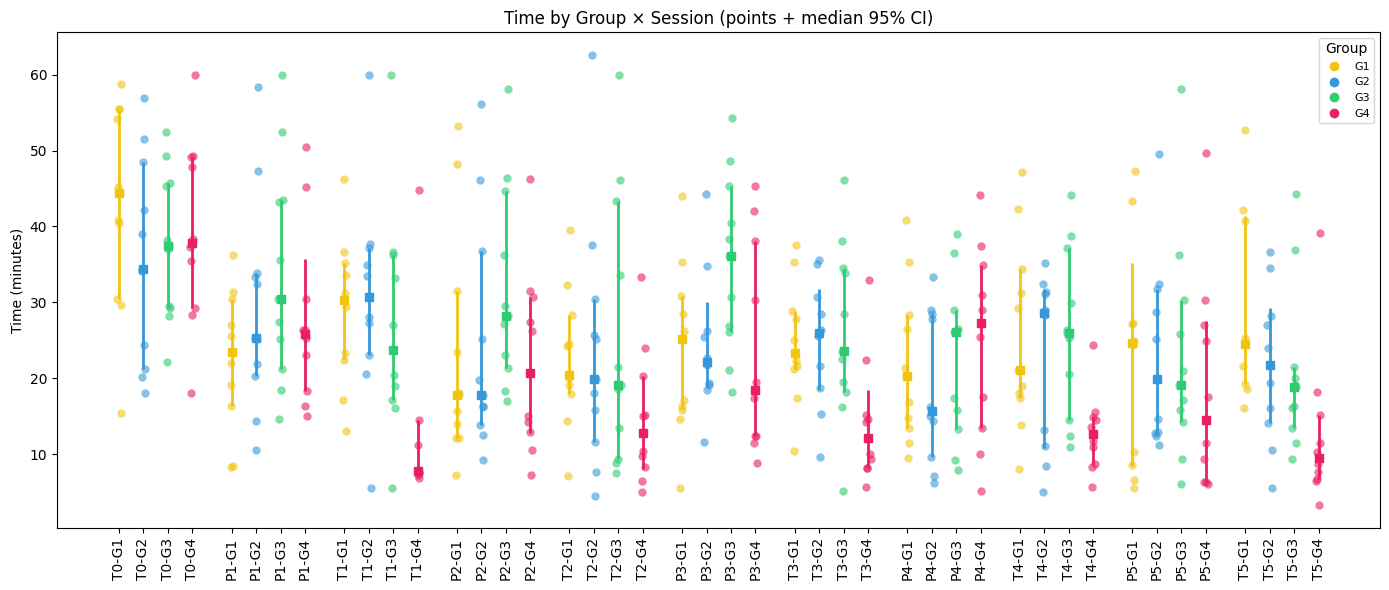

In [8]:

if "time_min" not in df.columns:
    print("No 'time_min' column found; skipping this plot.")
else:
    sessions = order_sessions(sorted(df["session"].unique()))
    fig, ax = plt.subplots(figsize=(14,6))
    xpos, labels, x = [], [], 0
    for s in sessions:
        sub = df[df["session"]==s]
        for g in GROUPS:
            gsub = sub[sub["group"]==g]
            y = gsub["time_min"].to_numpy(dtype=float)
            c = COLOR_MAP[g]
            xx = np.full_like(y, x, dtype=float) + (np.random.rand(len(y))-0.5)*0.2
            ax.plot(xx, y, 'o', alpha=0.6, markeredgewidth=0, color=c)
            med, lo, hi = bootstrap_ci(y, stat_func=np.median, B=2000)
            ax.plot([x], [med], 's', markersize=6, color=c)
            ax.vlines(x, lo, hi, color=c, lw=2)
            xpos.append(x); labels.append(f"{s}-{g}"); x += 1
        x += 0.6
    ax.set_xticks(xpos); ax.set_xticklabels(labels, rotation=90)
    ax.set_ylabel("Time (minutes)")
    ax.set_title("Time by Group × Session (points + median 95% CI)")
    handles = [plt.Line2D([0],[0], marker='o', linestyle='', color=COLOR_MAP[g], label=g) for g in GROUPS]
    ax.legend(handles=handles, title="Group", fontsize=8)
    fig.tight_layout()
    plt.show()


## Save figures

In [9]:

OUTDIR = "./figs"
os.makedirs(OUTDIR, exist_ok=True)

if "correctness" in df.columns:
    sessions = order_sessions(sorted(df["session"].unique()))
    fig, ax = plt.subplots(figsize=(14,6))
    xpos, labels, x = [], [], 0
    for s in sessions:
        sub = df[df["session"]==s]
        for g in GROUPS:
            gsub = sub[sub["group"]==g]
            y = gsub["correctness"].to_numpy(dtype=float)
            c = COLOR_MAP[g]
            xx = np.full_like(y, x, dtype=float) + (np.random.rand(len(y))-0.5)*0.2
            ax.plot(xx, y, 'o', alpha=0.6, markeredgewidth=0, color=c)
            mean, lo, hi = ci_prop(np.nanmean(y), len(y))
            ax.plot([x], [mean], 's', markersize=6, color=c)
            ax.vlines(x, lo, hi, color=c, lw=2)
            xpos.append(x); labels.append(f"{s}-{g}"); x += 1
        x += 0.6
    ax.set_xticks(xpos); ax.set_xticklabels(labels, rotation=90)
    ax.set_ylim(-0.05, 1.05); ax.set_ylabel("Correctness (proportion)")
    ax.set_title("Correctness by Group × Session (points + mean 95% CI)")
    handles = [plt.Line2D([0],[0], marker='o', linestyle='', color=COLOR_MAP[g], label=g) for g in GROUPS]
    ax.legend(handles=handles, title="Group", fontsize=8)
    fig.tight_layout()
    fig.savefig(os.path.join(OUTDIR, "fig_correctness_points_CI_by_group_session.png"), dpi=200)
    plt.close(fig)

if "time_min" in df.columns:
    sessions = order_sessions(sorted(df["session"].unique()))
    fig, ax = plt.subplots(figsize=(14,6))
    xpos, labels, x = [], [], 0
    for s in sessions:
        sub = df[df["session"]==s]
        for g in GROUPS:
            gsub = sub[sub["group"]==g]
            y = gsub["time_min"].to_numpy(dtype=float)
            c = COLOR_MAP[g]
            xx = np.full_like(y, x, dtype=float) + (np.random.rand(len(y))-0.5)*0.2
            ax.plot(xx, y, 'o', alpha=0.6, markeredgewidth=0, color=c)
            med, lo, hi = bootstrap_ci(y, stat_func=np.median, B=2000)
            ax.plot([x], [med], 's', markersize=6, color=c)
            ax.vlines(x, lo, hi, color=c, lw=2)
            xpos.append(x); labels.append(f"{s}-{g}"); x += 1
        x += 0.6
    ax.set_xticks(xpos); ax.set_xticklabels(labels, rotation=90)
    ax.set_ylabel("Time (minutes)")
    ax.set_title("Time by Group × Session (points + median 95% CI)")
    handles = [plt.Line2D([0],[0], marker='o', linestyle='', color=COLOR_MAP[g], label=g) for g in GROUPS]
    ax.legend(handles=handles, title="Group", fontsize=8)
    fig.tight_layout()
    fig.savefig(os.path.join(OUTDIR, "fig_time_points_CI_by_group_session.png"), dpi=200)
    plt.close(fig)

print("Saved to:", OUTDIR)


Saved to: ./figs
